## Theano

While most of PyMC3's user-facing features are written in pure Python, it leverages Theano (Bergstra et al., 2010) to transparently transcode models to C and compile them to machine code, thereby boosting performance. Theano is a library that allows expressions to be defined using generalized vector data structures called **tensors**, which are tightly integrated with the popular NumPy `ndarray` data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. Theano also automatically optimizes the likelihood's computational graph for speed and provides simple GPU integration.

Theano is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently. Theano features:

* __tight integration with numpy__ – Use numpy.ndarray in Theano-compiled functions.
* __transparent use of a GPU__ – Perform data-intensive calculations up to 140x faster than with CPU.(float32 only)
* __efficient symbolic differentiation__ – Theano does your derivatives for function with one or many inputs.
* __speed and stability optimizations__ – Get the right answer for log(1+x) even when x is really tiny.
* __dynamic C code generation__ – Evaluate expressions faster.
* __extensive unit-testing and self-verification__ – Detect and diagnose errors.

Theano is part programming language, part compiler. It is often used to build machine learning toolkit, just as packages like TensorFlow are, though it is not in itself a machine learning toolkit; think of it as a **mathematical toolkit**.

### Installing Theano

The easiest way to install Theano is to build it from source, using **pip**:

```bash
pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git
```

however, if you have PyMC3 installed, then Theano will already be available.

## Adding Two Scalars

To get us started with Theano and get a feel of what we're working with, let's make a simple function: *add two numbers together*. Here is how you do it:

### Step 1 - Declaring Variables

In [ ]:
from theano import function, shared
from theano import tensor as T
import theano

x = T.dscalar('x')
y = T.dscalar('y')

In Theano, all symbols must be typed. In particular, `T.dscalar`
is the type we assign to "0-dimensional arrays (`scalar`) of doubles
(`d`)". It is a Theano `type`.

In [ ]:
type(x)

In [ ]:
x.type

In [ ]:
T.dscalar

### Step 2 - Symbolic Expressions

The second step is to combine *x* and *y* into their sum *z*:

In [ ]:
z = x + y

*z* is yet another *Variable* which represents the addition of
*x* and *y*. You can use the `pp` function to *pretty-print* out the computation associated to *z*.


In [ ]:
from theano.printing import pp

print(pp(z))

### Step 3 - Compiling a Function

The last step is to create a function taking `x` and `y` as **inputs** and returning `z` as **output**:

In [ ]:
f = function([x, y], z)

The first argument to `function()` is a list of `Variable`s that will be provided as inputs to the function. The second argument is a single `Variable` *or* a list of `Variable`s. For either case, the second argument is what we want to see as output when we apply the function. `f` may then be used like a normal Python function.

Now we can call the function:

In [ ]:
f(2, 18)

In [ ]:
f(16.4, 12.1)

If you are following along and typing into an interpreter, you may have
noticed that there was a slight delay in executing the ``function``
instruction. Behind the scenes, *f* was being compiled into C code.

Internally, Theano builds a graph structure composed of interconnected `Variable` nodes, `op` nodes and `apply` nodes. 

An `apply` node represents the application of an `op` to some variables. It is important to draw the difference between the definition of a computation represented by an `op` and its application to some actual data which is represented by the apply node. 

Here is the expression graph corresponding to the addition of `x` and `y`:

In [ ]:

from theano import printing

printing.pydotprint(f, 'images/f.png')

In [ ]:
!conda install -y graphviz

In [ ]:
from IPython.display import Image
Image('images/f.png', width='80%')

A `Variable` is the main data structure you work with when using Theano. By calling `T.dscalar` with a string argument, you create a `Variable` representing a floating-point scalar quantity with the given name. If you provide no argument, the symbol will be unnamed. Names are not required, but they can help debugging.

## Adding Two Matrices

If we want to work with matrices instead of scalars, the only change
from the previous example is that you need to instantiate *x* and
*y* using the matrix Types:

In [ ]:
x = T.dmatrix('x')
y = T.dmatrix('y')
z = x + y
f = function([x, y], z)

``dmatrix`` is the Type for matrices of doubles. Then we can use
our new function on 2D arrays:


In [ ]:
f([[1, 2], [3, 4]], [[10, 20], [30, 40]])

The following types are available:

* **byte**: ``bscalar, bvector, bmatrix, brow, bcol, btensor3, btensor4``
* **16-bit integers**: ``wscalar, wvector, wmatrix, wrow, wcol, wtensor3, wtensor4``
* **32-bit integers**: ``iscalar, ivector, imatrix, irow, icol, itensor3, itensor4``
* **64-bit integers**: ``lscalar, lvector, lmatrix, lrow, lcol, ltensor3, ltensor4``
* **float**: ``fscalar, fvector, fmatrix, frow, fcol, ftensor3, ftensor4``
* **double**: ``dscalar, dvector, dmatrix, drow, dcol, dtensor3, dtensor4``
* **complex**: ``cscalar, cvector, cmatrix, crow, ccol, ctensor3, ctensor4``

An example of a slightly more interesting function is the **logistic curve**. Let's create a matrix, and apply the logistic transformation to it:

In [ ]:
x = T.dmatrix('x')

The logistic transformation:

In [ ]:
s = 1 / (1 + T.exp(-x))

In [ ]:
logistic = function([x], s)
logistic([[0, 1], [-1, -2]])

Theano supports functions with multiple outputs. For example, we can compute the **elementwise difference**, **absolute difference**, and **squared difference** between two matrices `a` and `b` at the same time.

In [ ]:
a, b = T.dmatrices('a', 'b')

# Operations
diff = a - b
abs_diff = abs(diff)
diff_squared = diff ** 2

When we use the function `f`, it returns the three computed results as a list.

In [ ]:
f = function([a, b], [diff, abs_diff, diff_squared])

f([[1, 1], [1, 1]], [[0, 1], [2, 3]])

## Setting a Default Value for an Argument
 
Let's say you want to define a function that adds two numbers, except that if you only provide one number, the other input is assumed to be one. In Python, the **default value** for parameters achieves this effect.

In Theano we make use of the <a href="http://deeplearning.net/software/theano/library/compile/io.html#function-inputs">`In`</a> class, which allows you to specify properties of your function's parameters with greater detail. Here we give a default value of 1 for `y` by creating an ``In`` instance with its ``value`` field set to 1. Inputs with default values must **follow** inputs without default values (like Python's functions).  There can be multiple inputs with default values. These parameters can be set positionally or by name, as in standard Python.

In [ ]:
from theano import In

x, y, w = T.dscalars('x', 'y', 'w')
z = (x + y) * w
g = function([x, In(y, value=1), In(w, value=2, name='w_by_name')], z)

In [ ]:
print('g(33) = {}'.format(g(33)))

In [ ]:
print('g(33, 0, 1) = {}'.format(g(33, 0, 1)))

In [ ]:
print('g(33, w_by_name=1) = {}'.format(g(33, w_by_name=1)))

In [ ]:
print('g(33, w_by_name=1, y=0) = {}'.format(g(33, w_by_name=1, y=0)))

## Maintaining State with Shared Variables

It is also possible to make a function with an internal state. For example, let’s say we want to make an **accumulator**: at the beginning, the state is initialized to zero. Then, on each function call, the state is incremented by the function’s argument.

First let’s define the accumulator function. It adds its argument to the internal state, and returns the old state value.

In [ ]:
state = shared(0)
inc = T.iscalar('inc')
accumulator = function([inc], state, updates=[(state, state+inc)])

This code introduces a couple of new concepts. The `shared` function constructs so-called **shared variables**. 

    state = shared(0)

These are hybrid symbolic and non-symbolic variables whose value may be shared between multiple functions. 

Shared variables can be used in symbolic expressions but they also have an internal value that defines the value taken by this symbolic variable in all the functions that use it. It is called a shared variable because its value is shared between many functions. The value can be accessed and modified by the `get_value` and `set_value` methods.

The other new thing in this code is the `updates` parameter of function. 

    updates=[(state, state+inc)

`updates` must be supplied with a list of pairs of the form `(shared-variable, new expression)`. It can also be a dictionary whose keys are shared-variables and values are the new expressions. Here, the accumulator replaces the `state`‘s value with the sum of `state` and the increment amount `inc`.

In [ ]:
print(state.get_value())

In [ ]:
print(accumulator(1))

In [ ]:
print(state.get_value())

In [ ]:
print(accumulator(300))

In [ ]:
print(state.get_value())

It is possible to reset the state. Just use the `set_value` method:

In [ ]:
state.set_value(-1)

In [ ]:
print(accumulator(3))

In [ ]:
print(state.get_value())

As we mentioned above, you can define more than one function to use the same shared variable. These functions can all update the value.

In [ ]:
decrementor = function([inc], state, updates=[(state, state-inc)])

In [ ]:
print(decrementor(2))

In [ ]:
print(state.get_value())

You might be wondering why the updates mechanism exists. You can always achieve a similar result by returning the new expressions, and working with them in NumPy as usual. 

While the updates mechanism can be a syntactic convenience, it is mainly there for **efficiency**. Updates to shared variables can sometimes be done more quickly using in-place algorithms (*e.g.* low-rank matrix updates). 

Also, Theano has more control over where and how shared variables are allocated, which is one of the important elements of getting good performance on the GPU.

### Exercise: Create and manipulate Theano objects

To give you some practice with basic Theano data structures and functions, try making the operations below work by implementing the functions that are needed.

In [ ]:
def make_vector():
    """
    Create and return a new Theano vector.
    """

    pass

def make_matrix():
    """
    Create and return a new Theano matrix.
    """

    pass

def elemwise_mul(a, b):
    """
    a: A theano matrix
    b: A theano matrix
    
    Calcuate the elementwise product of a and b and return it
    """

    pass

def matrix_vector_mul(a, b):
    """
    a: A theano matrix
    b: A theano vector
    
    Calculate the matrix-vector product of a and b and return it
    """

    pass

a = make_vector()
b = make_vector()
c = elemwise_mul(a, b)
d = make_matrix()
e = matrix_vector_mul(d, c)

f = function([a, b, d], e)

import numpy as np
rng = np.random.RandomState([1, 2, 3])
a_value = rng.randn(5).astype(a.dtype)
b_value = rng.rand(5).astype(b.dtype)
c_value = a_value * b_value
d_value = rng.randn(5, 5).astype(d.dtype)
expected = np.dot(d_value, c_value)

actual = f(a_value, b_value, d_value)

assert np.allclose(actual, expected)
print("SUCCESS!")

### Example: Logistic regression

Here is a non-trivial example, which uses Theano to estimate the parameters of a logistic regression model using gradient information. We will use the bioassay example as a test case:

In [ ]:
import numpy as np

rng = np.random

dose = np.array([-0.86, -0.3 , -0.05,  0.73])
deaths = np.array([0, 1, 3, 5])
training_steps = 1000

We first declare Theano symbolic variables:

In [ ]:
x = T.vector("x")
y = T.vector("y")
w = theano.shared(1., name="w")
b = theano.shared(0., name="b")

print("Initial model:", w.get_value(), b.get_value())

... then construct the expression graph:

In [ ]:
# Probability that target = 1
p_1 = 1 / (1 + T.exp(-(x*w + b))) 

# The prediction threshold
prediction = p_1 > 0.5         

# Cross-entropy loss function
xent = -y * T.log(p_1) - (5-y) * T.log(1-p_1) 

# The cost to minimize
cost = xent.mean()      

# Compute the gradient of the cost
gw, gb = T.grad(cost, [w, b])                  

Compile Theano functions:

In [ ]:
step = theano.shared(10., name='step')
train = theano.function(
          inputs=[x, y],
          outputs=[prediction, xent],
          updates=((w, w - step * gw), (b, b - step * gb), (step, step * 0.99)))
predict = theano.function(inputs=[x], outputs=prediction)

Train model:

In [ ]:
for i in range(training_steps):
    pred, err = train(dose, deaths)

print("Final model:", w.get_value(), b.get_value())

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

logit = lambda x: 1. / (1 + np.exp(-x))
xvals = np.linspace(-1, 1)
plt.plot(xvals, logit(7.8*xvals + .85))
plt.plot(dose, deaths/5., 'ro')

## Exercises: Gradients and functions

Let's try using the Theano automatic gradient system to compute derivatives.

In [ ]:
def grad_sum(x, y, z):
    """
    x: A theano variable
    y: A theano variable
    z: A theano expression involving x and y
    Returns dz / dx + dz / dy
    """

    pass

x = T.scalar()
y = T.scalar()
z = x + y
s = grad_sum(x, y, z)
assert s.eval({x: 0, y: 0}) == 2
print("SUCCESS!")

### Random Numbers

Because in Theano you first express everything symbolically and afterwards compile this expression to get functions, using **pseudo-random numbers** is not as straightforward as it is in NumPy.

The way to think about putting randomness into Theano’s computations is to put random variables in your graph. Theano will allocate a NumPy `RandomStream` object (a random number generator) for each such variable, and draw from it as necessary. We will call this sort of sequence of random numbers a random stream.

In [ ]:
from theano.tensor.shared_randomstreams import RandomStreams

srng = RandomStreams(seed=234)
rv_u = srng.uniform((2,2))
f = function([], rv_u)

In [ ]:
f()

In [ ]:
f()

## Looping in Theano

The `scan` function provides the ability to write **loops** in Theano. We are not able to use Python `for` loops with Theano because Theano needs to be able to build and optimize the expression graph before compiling it into faster code, and be able to use symbolic differentiation for calculating gradients.

### Simple loop with accumulation

Assume that, given $k$ you want to get $A^k$ using a loop. More precisely, if $A$ is a tensor you want to compute $A^k$ elementwise. The python code might look like:

```python
result = 1
for i in range(k):
  result = result * A
```

There are three things here that we need to handle: the initial value assigned to result, the accumulation of results in result, and the unchanging variable A. Unchanging variables are passed to scan as non_sequences. Initialization occurs in outputs_info, and the accumulation happens automatically.

The equivalent Theano code would be:

In [ ]:
k = T.iscalar("k")
A = T.vector("A")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=final_result, updates=updates)

print(power(range(10),2))
print(power(range(10),4))

Let us go through the example line by line. What we did is first to **construct a function** (using a lambda expression) that given `prior_result` and `A` returns `prior_result * A`. The order of parameters is fixed by `scan`: the output of the prior call to `fn` is the first parameter, followed by all non-sequences.

Next we **initialize the output** as a tensor with same shape and `dtype` as `A`, filled with ones. We give `A` to `scan` as a non sequence parameter and specify the number of steps `k` to iterate over our `lambda` expression.

Scan **returns a tuple** containing our result (`result`) and a dictionary of updates (empty in this case). Note that the result is not a matrix, but a 3D tensor containing the value of $A^k$ for each step. We want the last value (after k steps) so we compile a function to return just that. 

Note that there is an **optimization**, that at compile time will detect that you are using just the last value of the result and ensure that scan does not store all the intermediate values that are used. So do not worry if `A` and `k` are large.

In addition to looping a fixed number of times, scan can iterate over the leading dimension of tensors (similar to Python’s **list comprehension** `for x in a_list`).

The tensor(s) to be looped over should be provided to `scan` using the `sequence` keyword argument.

Here’s an example that builds a **symbolic calculation of a polynomial** from a list of its coefficients:

In [ ]:
coefficients = theano.tensor.vector("coefficients")
x = T.scalar("x")

# Generate the components of the polynomial
components, updates = theano.scan(fn=lambda coefficient, power, val: coefficient * (val ** power),
                                  outputs_info=None,
                                  sequences=[coefficients, theano.tensor.arange(1000)],
                                  non_sequences=x)
# Sum them up
polynomial = components.sum()

# Compile a function
calculate_polynomial = theano.function(inputs=[coefficients, x], outputs=polynomial)

# Test
test_coefficients = np.asarray([1, 0, 2], dtype=np.float32)
test_value = 3
print(calculate_polynomial(test_coefficients, test_value))

## Gradient-based sampling methods in PyMC3

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3's most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. 


PyMC3 relies on Theano to analytically compute **model gradients** via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables. 

## Comparison of Metropolis and NUTS

As an informal comparison, we will demonstrate samples generated from a simple statistical model using both the Metropolis and NUTS sampler in PyMC3. The set of examples includes a univariate linear model that is fit to simulated data via the `glm` module. 

```python
with Model() as model:
    glm.glm('y ~ x', data)
```

The model contains three parameters (intercept, slope and sampling standard deviation), each of which is continuous, so the model can be fit by either algorithm. We will run a short chain for each, and compare the output graphically:

In [90]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

In [91]:
from pymc3 import sample, Metropolis, NUTS


In [92]:
with pm.Model() as glm_linear_model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('Intercept', 0, sd=20)
    x_coeff = pm.Normal('x', 0, sd=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)



In [93]:
with glm_linear_model:
    trace_metropolis = pm.sample(1000, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [x]
>Metropolis: [Intercept]
>Metropolis: [sigma]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4148.27draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [94]:
with glm_linear_model:
    trace_nuts = pm.sample(1000, step=pm.NUTS())

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, sigma]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1930.43draws/s]


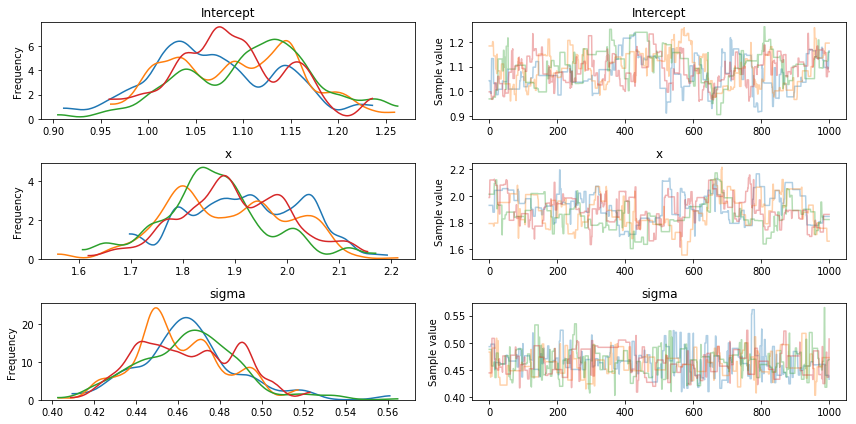

In [95]:
pm.traceplot(trace_metropolis);

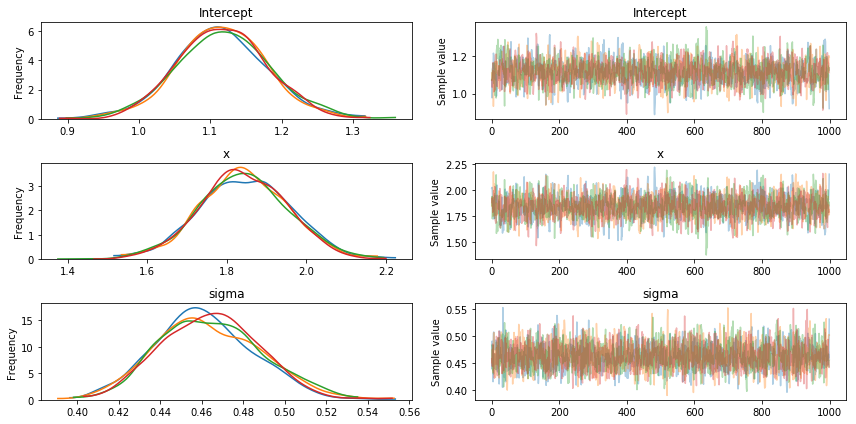

In [96]:
pm.traceplot(trace_nuts);

The samples from `Metropolis` shows very poor mixing during the first 1000 iterations, and has clearly not converged. The `NUTS` samples are more homogeneous, with better mixing and less autocorrelation.

## References

1. [DeepLearning documentation and tutorials](http://deeplearning.net/tutorial/contents.html)

